Cell 1 – Import libraries

In [33]:
import os
import random
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Cell 2 – Load the dataset

In [20]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/animal_dataset"

print("Path to dataset files:", path)
print("Folders inside path:", os.listdir(path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path to dataset files: /content/drive/MyDrive/animal_dataset
Folders inside path: ['panda', 'dog', 'cat']


Cell 3 – Build the category list

In [21]:
categories_path = path

categories = [c for c in os.listdir(categories_path)
              if os.path.isdir(os.path.join(categories_path, c))]
print("categories:", categories)

categories: ['panda', 'dog', 'cat']


Cell 4 – Preprocess and randomly select 100 images per class

In [22]:
train_data = []

for c in categories:
  print("\nProcessing category:", c)

  individual_category_path = os.path.join(categories_path, c)

  class_idx = categories.index(c)


  category_imgs = os.listdir(individual_category_path)

  selected_imgs = random.sample(category_imgs, 100)

  for img in tqdm(selected_imgs, desc=f"{c} images"):
    img_path = os.path.join(individual_category_path, img)

    try:
      single_img = cv.imread(img_path)
      single_img = cv.cvtColor(single_img, cv.COLOR_BGR2GRAY)
      single_img = cv.resize(single_img, (32, 32))
      train_data.append([single_img, class_idx])
    except Exception as e:
      print("error:", e)

print("\nSize of dataset:", len(train_data))


Processing category: panda


panda images: 100%|██████████| 100/100 [00:01<00:00, 65.09it/s]



Processing category: dog


dog images: 100%|██████████| 100/100 [00:00<00:00, 107.87it/s]



Processing category: cat


cat images: 100%|██████████| 100/100 [00:00<00:00, 108.61it/s]


Size of dataset: 300


Cell 5 – Visual check

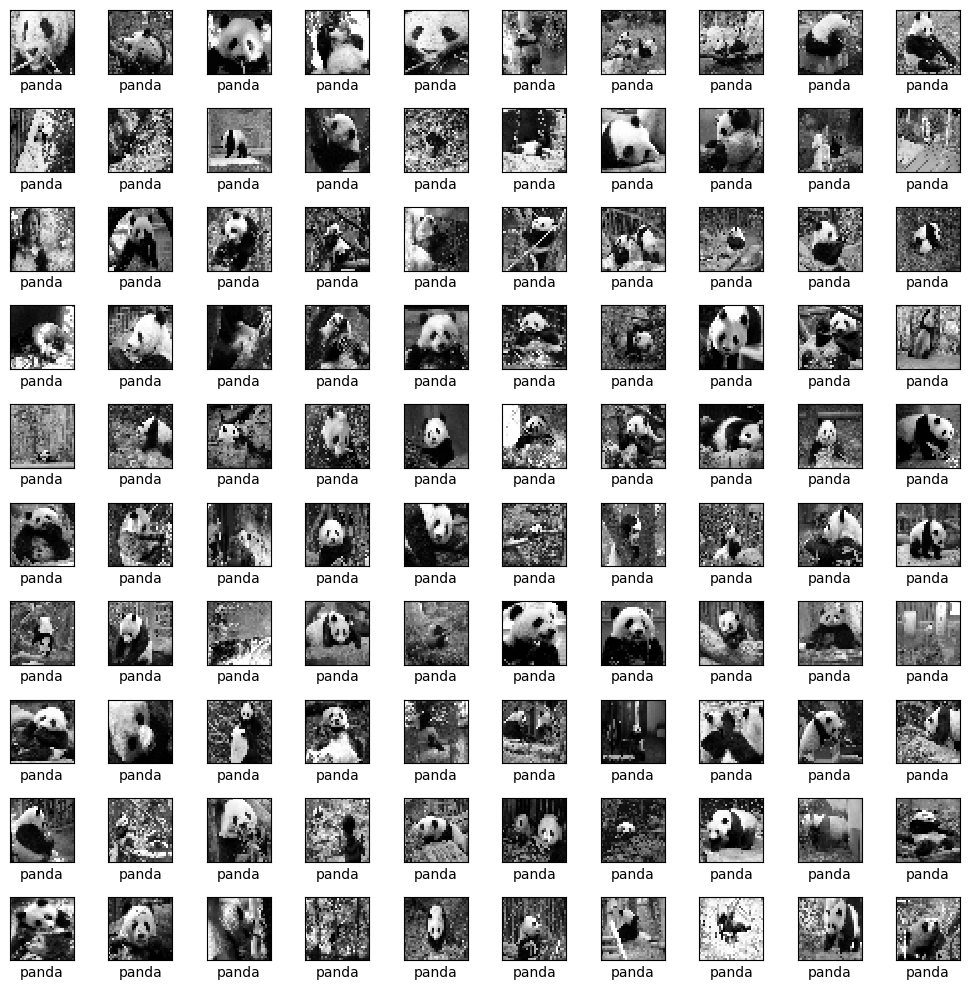

In [23]:
plt.figure(figsize=(10, 10))
i = 0
for r in range(10):
  for c in range(10):
    plt.subplot(10, 10, i + 1)
    plt.imshow(train_data[i][0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(categories[train_data[i][1]])
    i += 1
plt.tight_layout()
plt.show()

Cell 6 – Flatten and normalize

In [24]:
images = np.array([img[0] for img in train_data])
labels = np.array([label[1] for label in train_data])

print("Original image array shape:", images.shape)

images = images.reshape(images.shape[0], -1)
print("Flattened images shape:", images.shape)

images = images.astype("float32") / 255.0

Original image array shape: (300, 32, 32)
Flattened images shape: (300, 1024)


Cell 7 – 5-fold cross-validation (L1 vs L2)

In [25]:
# 5-fold cross validation
n_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# values of K to try
k_values = [1, 3, 5, 7, 9]

# store accuracies for each K and each distance
l1_accuracies = {k: [] for k in k_values}
l2_accuracies = {k: [] for k in k_values}

print("Starting cross-validation...")

for fold, (train_idx, val_idx) in enumerate(n_fold.split(images)):
  print(f"\nProcessing fold {fold + 1}...")

  # split dataset into training and validation for current fold
  x_train, x_val = images[train_idx], images[val_idx]
  y_train, y_val = labels[train_idx], labels[val_idx]

  # evaluate different k values for both L1 and L2 distances
  for k in k_values:
    # L1 distance (Manhattan) -> p=1
    knn_l1 = KNeighborsClassifier(n_neighbors=k, p=1)
    knn_l1.fit(x_train, y_train)
    y_pred_l1 = knn_l1.predict(x_val)
    accuracy_l1 = accuracy_score(y_val, y_pred_l1)
    l1_accuracies[k].append(accuracy_l1)

    # L2 distance (Euclidean) -> p=2
    knn_l2 = KNeighborsClassifier(n_neighbors=k, p=2)
    knn_l2.fit(x_train, y_train)
    y_pred_l2 = knn_l2.predict(x_val)
    accuracy_l2 = accuracy_score(y_val, y_pred_l2)
    l2_accuracies[k].append(accuracy_l2)

    print(
        f"Fold {fold + 1}, K={k}: "
        f"L1 Accuracy={accuracy_l1:.4f}, L2 Accuracy={accuracy_l2:.4f}"
    )

Starting cross-validation...

Processing fold 1...
Fold 1, K=1: L1 Accuracy=0.3500, L2 Accuracy=0.3333
Fold 1, K=3: L1 Accuracy=0.3333, L2 Accuracy=0.3833
Fold 1, K=5: L1 Accuracy=0.3500, L2 Accuracy=0.3500
Fold 1, K=7: L1 Accuracy=0.4167, L2 Accuracy=0.2833
Fold 1, K=9: L1 Accuracy=0.4000, L2 Accuracy=0.2833

Processing fold 2...
Fold 2, K=1: L1 Accuracy=0.2667, L2 Accuracy=0.3333
Fold 2, K=3: L1 Accuracy=0.3167, L2 Accuracy=0.2833
Fold 2, K=5: L1 Accuracy=0.4000, L2 Accuracy=0.3000
Fold 2, K=7: L1 Accuracy=0.3667, L2 Accuracy=0.3167
Fold 2, K=9: L1 Accuracy=0.4000, L2 Accuracy=0.3167

Processing fold 3...
Fold 3, K=1: L1 Accuracy=0.5167, L2 Accuracy=0.4000
Fold 3, K=3: L1 Accuracy=0.4167, L2 Accuracy=0.4167
Fold 3, K=5: L1 Accuracy=0.5000, L2 Accuracy=0.4000
Fold 3, K=7: L1 Accuracy=0.5000, L2 Accuracy=0.5000
Fold 3, K=9: L1 Accuracy=0.4667, L2 Accuracy=0.5333

Processing fold 4...
Fold 4, K=1: L1 Accuracy=0.2333, L2 Accuracy=0.2000
Fold 4, K=3: L1 Accuracy=0.3167, L2 Accuracy=0.3000

Cell 8 – Plot accuracy vs K for L1 and L2

Average L1 accuracies: [np.float64(0.33333333333333337), np.float64(0.33666666666666667), np.float64(0.39), np.float64(0.3966666666666666), np.float64(0.4033333333333333)]
Average L2 accuracies: [np.float64(0.29333333333333333), np.float64(0.3466666666666667), np.float64(0.33333333333333326), np.float64(0.3466666666666667), np.float64(0.3433333333333334)]


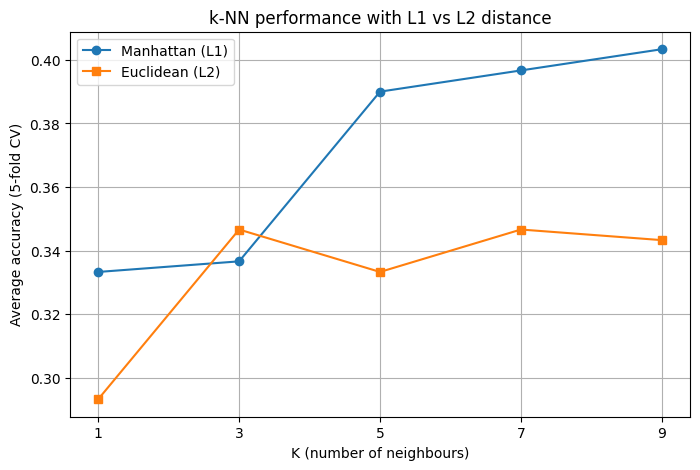

In [26]:
avg_acc_l1 = [np.mean(l1_accuracies[k]) for k in k_values]
avg_acc_l2 = [np.mean(l2_accuracies[k]) for k in k_values]

print("Average L1 accuracies:", avg_acc_l1)
print("Average L2 accuracies:", avg_acc_l2)

plt.figure(figsize=(8, 5))
plt.plot(k_values, avg_acc_l1, marker='o', label='Manhattan (L1)')
plt.plot(k_values, avg_acc_l2, marker='s', label='Euclidean (L2)')

plt.xlabel("K (number of neighbours)")
plt.ylabel("Average accuracy (5-fold CV)")
plt.title("k-NN performance with L1 vs L2 distance")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

Cell 9 – Choose best K and train final model

In [27]:
mean_l1 = {k: np.mean(l1_accuracies[k]) for k in k_values}
mean_l2 = {k: np.mean(l2_accuracies[k]) for k in k_values}

best_k_l1 = max(mean_l1, key=mean_l1.get)
best_k_l2 = max(mean_l2, key=mean_l2.get)

print("Best L1 (Manhattan): K =", best_k_l1, "accuracy =", mean_l1[best_k_l1])
print("Best L2 (Euclidean): K =", best_k_l2, "accuracy =", mean_l2[best_k_l2])

if mean_l1[best_k_l1] >= mean_l2[best_k_l2]:
  best_k = best_k_l1
  best_metric = 1  # L1
else:
  best_k = best_k_l2
  best_metric = 2  # L2

print("\nUsing final model with:")
print("K =", best_k, "metric =", "L1 (p=1)" if best_metric == 1 else "L2 (p=2)")

final_knn = KNeighborsClassifier(n_neighbors=best_k, p=best_metric)
final_knn.fit(images, labels)

Best L1 (Manhattan): K = 9 accuracy = 0.4033333333333333
Best L2 (Euclidean): K = 3 accuracy = 0.3466666666666667

Using final model with:
K = 9 metric = L1 (p=1)


KNeighborsClassifier(n_neighbors=9, p=1)

Cell 10 – Build a simple “test set”

In [28]:
test_data = []

for c in categories:
  print("\nBuilding test data for:", c)
  individual_category_path = os.path.join(categories_path, c)
  class_idx = categories.index(c)

  category_imgs = sorted(os.listdir(individual_category_path))

  selected_imgs = category_imgs[-5:]

  for img in selected_imgs:
    img_path = os.path.join(individual_category_path, img)
    try:
      single_img = cv.imread(img_path)
      single_img = cv.cvtColor(single_img, cv.COLOR_BGR2GRAY)
      single_img = cv.resize(single_img, (32, 32))
      test_data.append([single_img, class_idx])
    except Exception as e:
      print("error:", e)

print("\nTest set size:", len(test_data))


Building test data for: panda

Building test data for: dog

Building test data for: cat

Test set size: 15


Cell 11 – Display test images

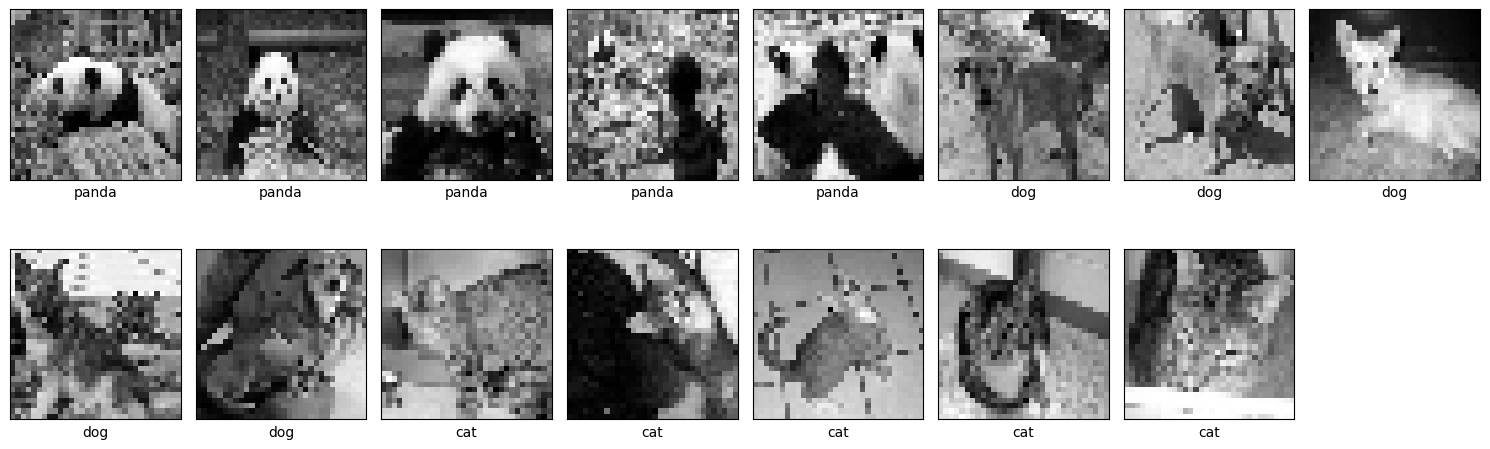

In [29]:
plt.figure(figsize=(15, 5))
for i in range(len(test_data)):
  plt.subplot(2, (len(test_data) + 1) // 2, i + 1)
  plt.imshow(test_data[i][0], cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(categories[test_data[i][1]])
plt.tight_layout()
plt.show()

Cell 12 – Flatten and normalize the test set

In [30]:
x_test = np.array([img[0] for img in test_data])
y_test = np.array([img[1] for img in test_data])

x_test = x_test.reshape(x_test.shape[0], -1)
x_test = x_test.astype("float32") / 255.0

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (15, 1024)
y_test shape: (15,)


Cell 13 – Top 5 predictions with images

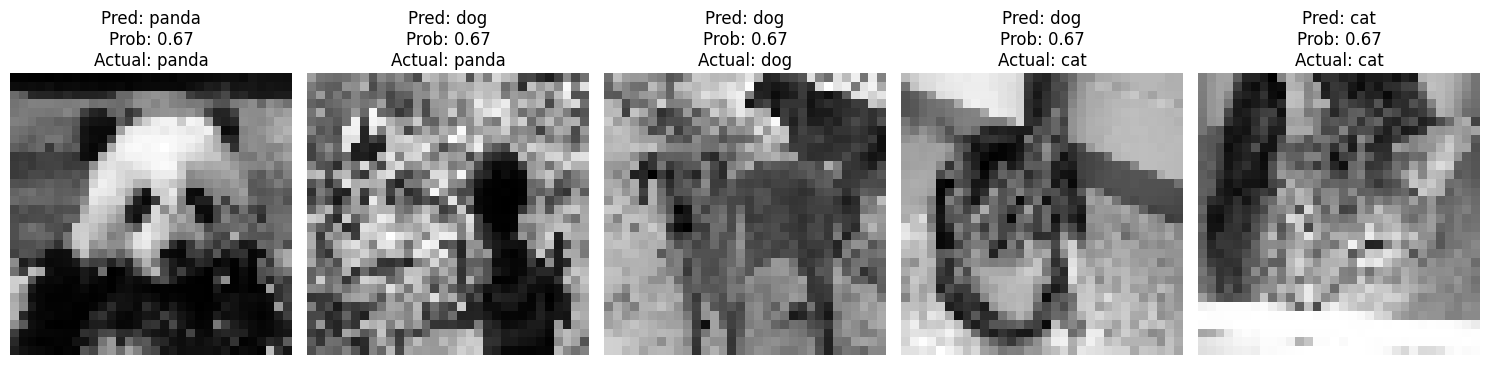

In [31]:
probabilities = final_knn.predict_proba(x_test)

predicted_classes = final_knn.predict(x_test)

predictions_with_details = []
for i in range(len(x_test)):
  predictions_with_details.append({
      "prediction": predicted_classes[i],
      "probability": float(np.max(probabilities[i])),
      "actual": y_test[i],
      "image": test_data[i][0]
  })

predictions_with_details.sort(key=lambda x: x["probability"], reverse=True)

top5_predictions = predictions_with_details[:5]

plt.figure(figsize=(15, 5))
for i, pred in enumerate(top5_predictions):
  plt.subplot(1, 5, i + 1)
  plt.imshow(pred["image"], cmap="gray")
  pred_label = categories[pred["prediction"]]
  actual_label = categories[pred["actual"]]
  plt.title(f"Pred: {pred_label}\nProb: {pred['probability']:.2f}\nActual: {actual_label}")
  plt.axis("off")
plt.tight_layout()
plt.show()